## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
from src.utils import get_toy_data_indep, plot_ppds

from src.attacks.distr_attacks import fgsm_attack, mlmc_attack, mlmc_gradient_estimator, kl_div, kl_maximization, kl_to_appd

import numpy as np
import torch
from torch.optim import SGD
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

import time
from joblib import Parallel, delayed

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
X, y = get_toy_data_indep(100)

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.9, random_state=42)

In [5]:
# X_gray = X_test[-10:, :]
# y_gray = y_test[-10:]

np.random.seed(0)

Ad = np.eye(2)
X_gray = np.random.multivariate_normal([0, 0], Ad, 10)

beta_gray = np.array([0, 2])

y_gray = X_gray @ beta_gray + np.random.normal(0, 1, 10)

X_gray = scaler.fit_transform(X_gray)

In [6]:
# Model for which we know the true gradient
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [7]:
# Fit the model
model_adv = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': 2 * torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data_adv = {'X': torch.tensor(X_gray, dtype=torch.float32), 'y': torch.tensor(y_gray, dtype=torch.float32)}
model_adv.fit(data_adv)

In [ ]:
torch.inverse(2*torch.eye(2))

tensor([[0.5000, 0.0000],
        [0.0000, 0.5000]])

In [9]:
torch.inverse(model.lam)

tensor([[ 0.4041, -0.2379],
        [-0.2379,  0.4280]])

In [10]:
print(X_test[1,:])

[0.43341015 0.33061164]


## APPD = N(mu, 2*sigma)

### Check gradient

In [11]:
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, np.sqrt(2) * std)
x_adv = x.clone().detach().requires_grad_(True)  
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = kl_to_appd(model.mu, model.lam, model.sigma2, x_adv, x.T @ model.mu, 2 * std ** 2)
kl.backward()
real_grad = x_adv.grad.clone().detach()

In [12]:
grads = []
for it in range(1000):  # TODO: change to 10000
    grads.append(-mlmc_gradient_estimator(appd.sample(), x_adv, 10, model))

# Plot 2 histograms, one for each feature
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].hist([grad[i].item() for grad in grads], bins=20)
    axs[i].axvline(real_grad[i].item(), color='red')
    axs[i].set_xlabel(f'Gradient {i}')
    axs[i].set_ylabel('Counts')

KeyboardInterrupt: 

Early stopping at iteration 209


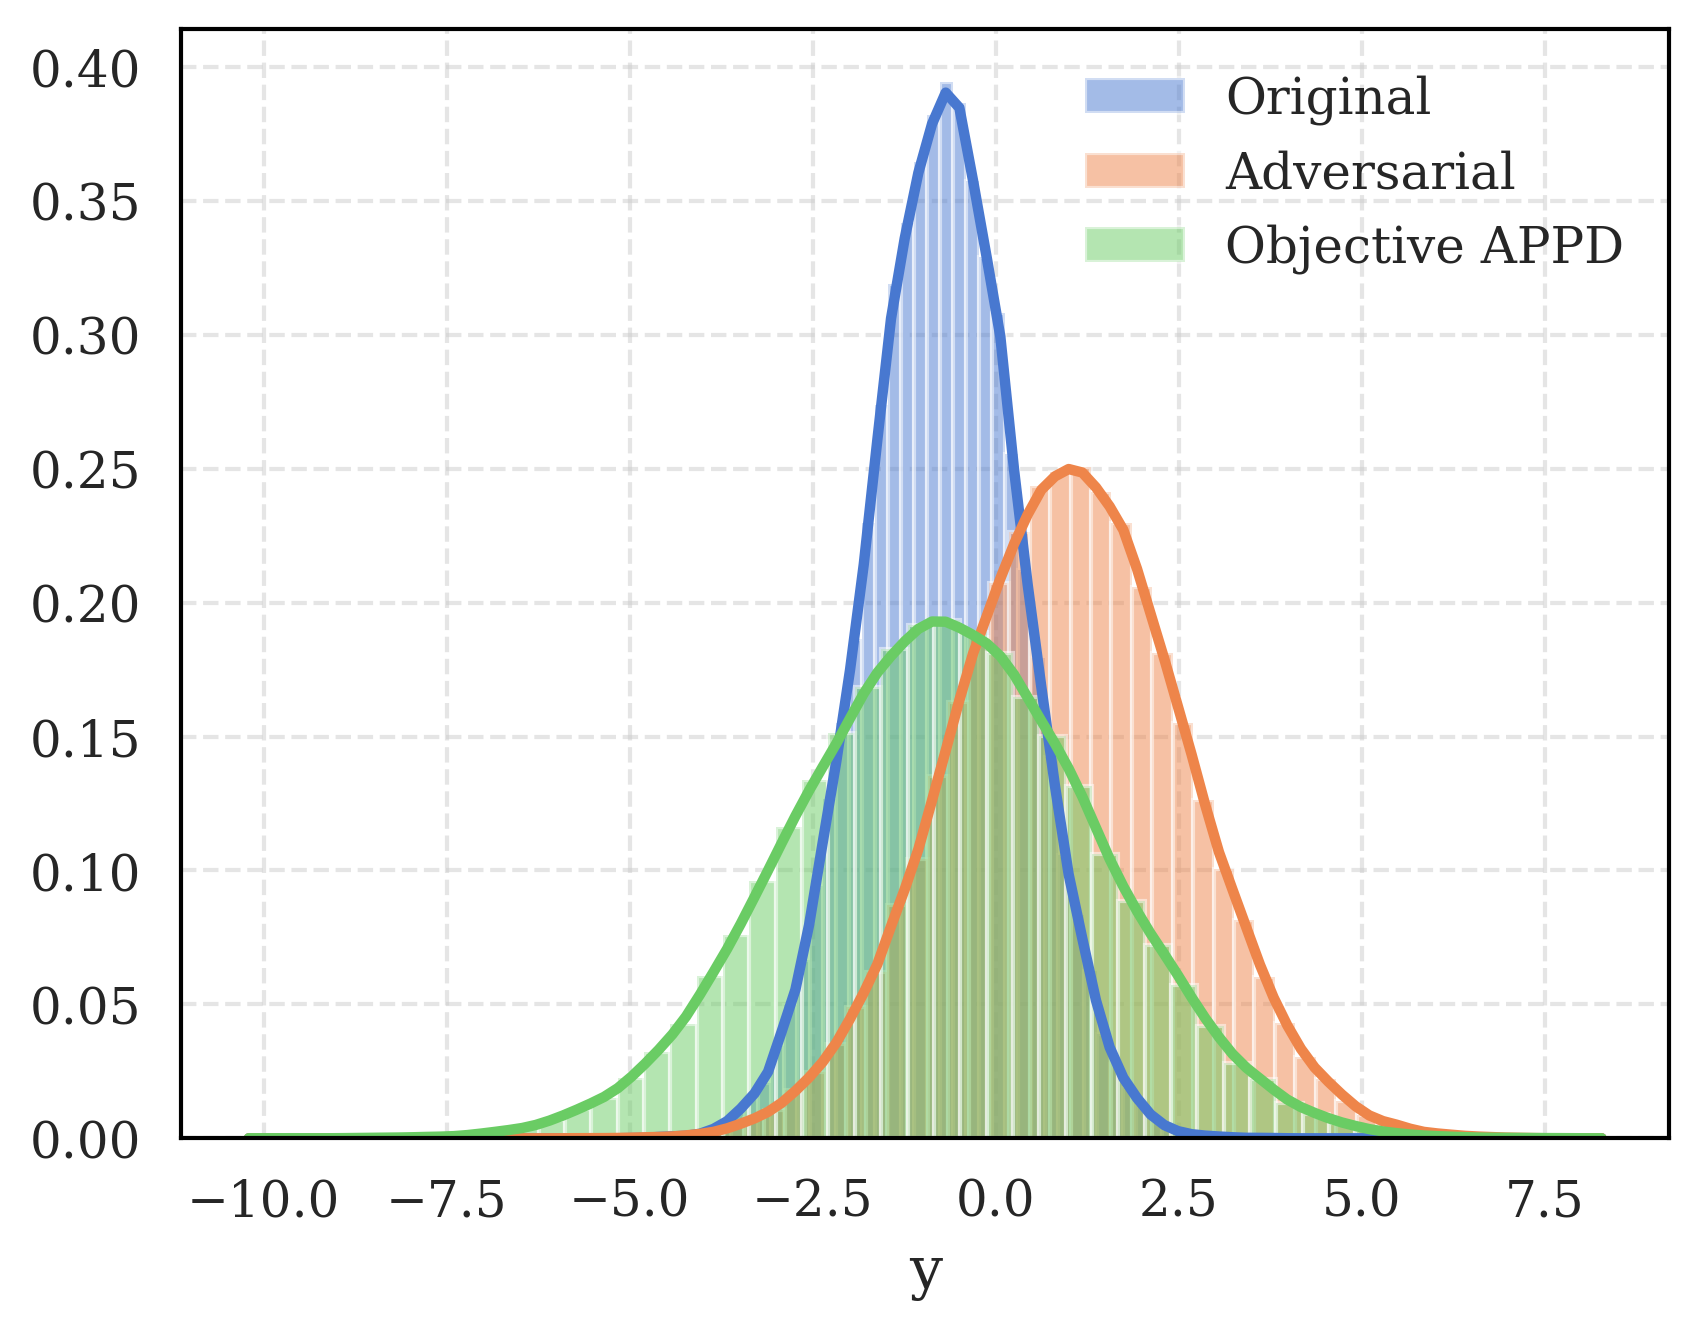

In [13]:
# Attack example
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=.1, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

In [14]:
print(f'Punto inicial: {x} con varianza {std**2}.\n Punto final: {x_adv_distr} con varianza {model.sample_predictive_distribution(x_adv_distr, 10000).var()}')

Punto inicial: tensor([[0.4334],
        [0.3306]]) con varianza 1.061564564704895.
 Punto final: tensor([[0.9538],
        [2.2617]]) con varianza 2.552060842514038


Early stopping at iteration 18
Early stopping at iteration 29
Early stopping at iteration 27
Early stopping at iteration 21
Early stopping at iteration 21
Early stopping at iteration 21
Early stopping at iteration 21
Early stopping at iteration 18
Early stopping at iteration 20
Early stopping at iteration 17
Early stopping at iteration 20
Early stopping at iteration 28
Early stopping at iteration 36
Early stopping at iteration 24
Early stopping at iteration 22
Early stopping at iteration 24
Early stopping at iteration 33
Early stopping at iteration 36
Early stopping at iteration 29
Early stopping at iteration 28
Early stopping at iteration 30
Early stopping at iteration 39
Early stopping at iteration 40
Early stopping at iteration 38
Early stopping at iteration 41
Early stopping at iteration 41
Early stopping at iteration 62
Early stopping at iteration 44
Early stopping at iteration 58
Early stopping at iteration 45
Early stopping at iteration 64
Early stopping at iteration 53
Early st

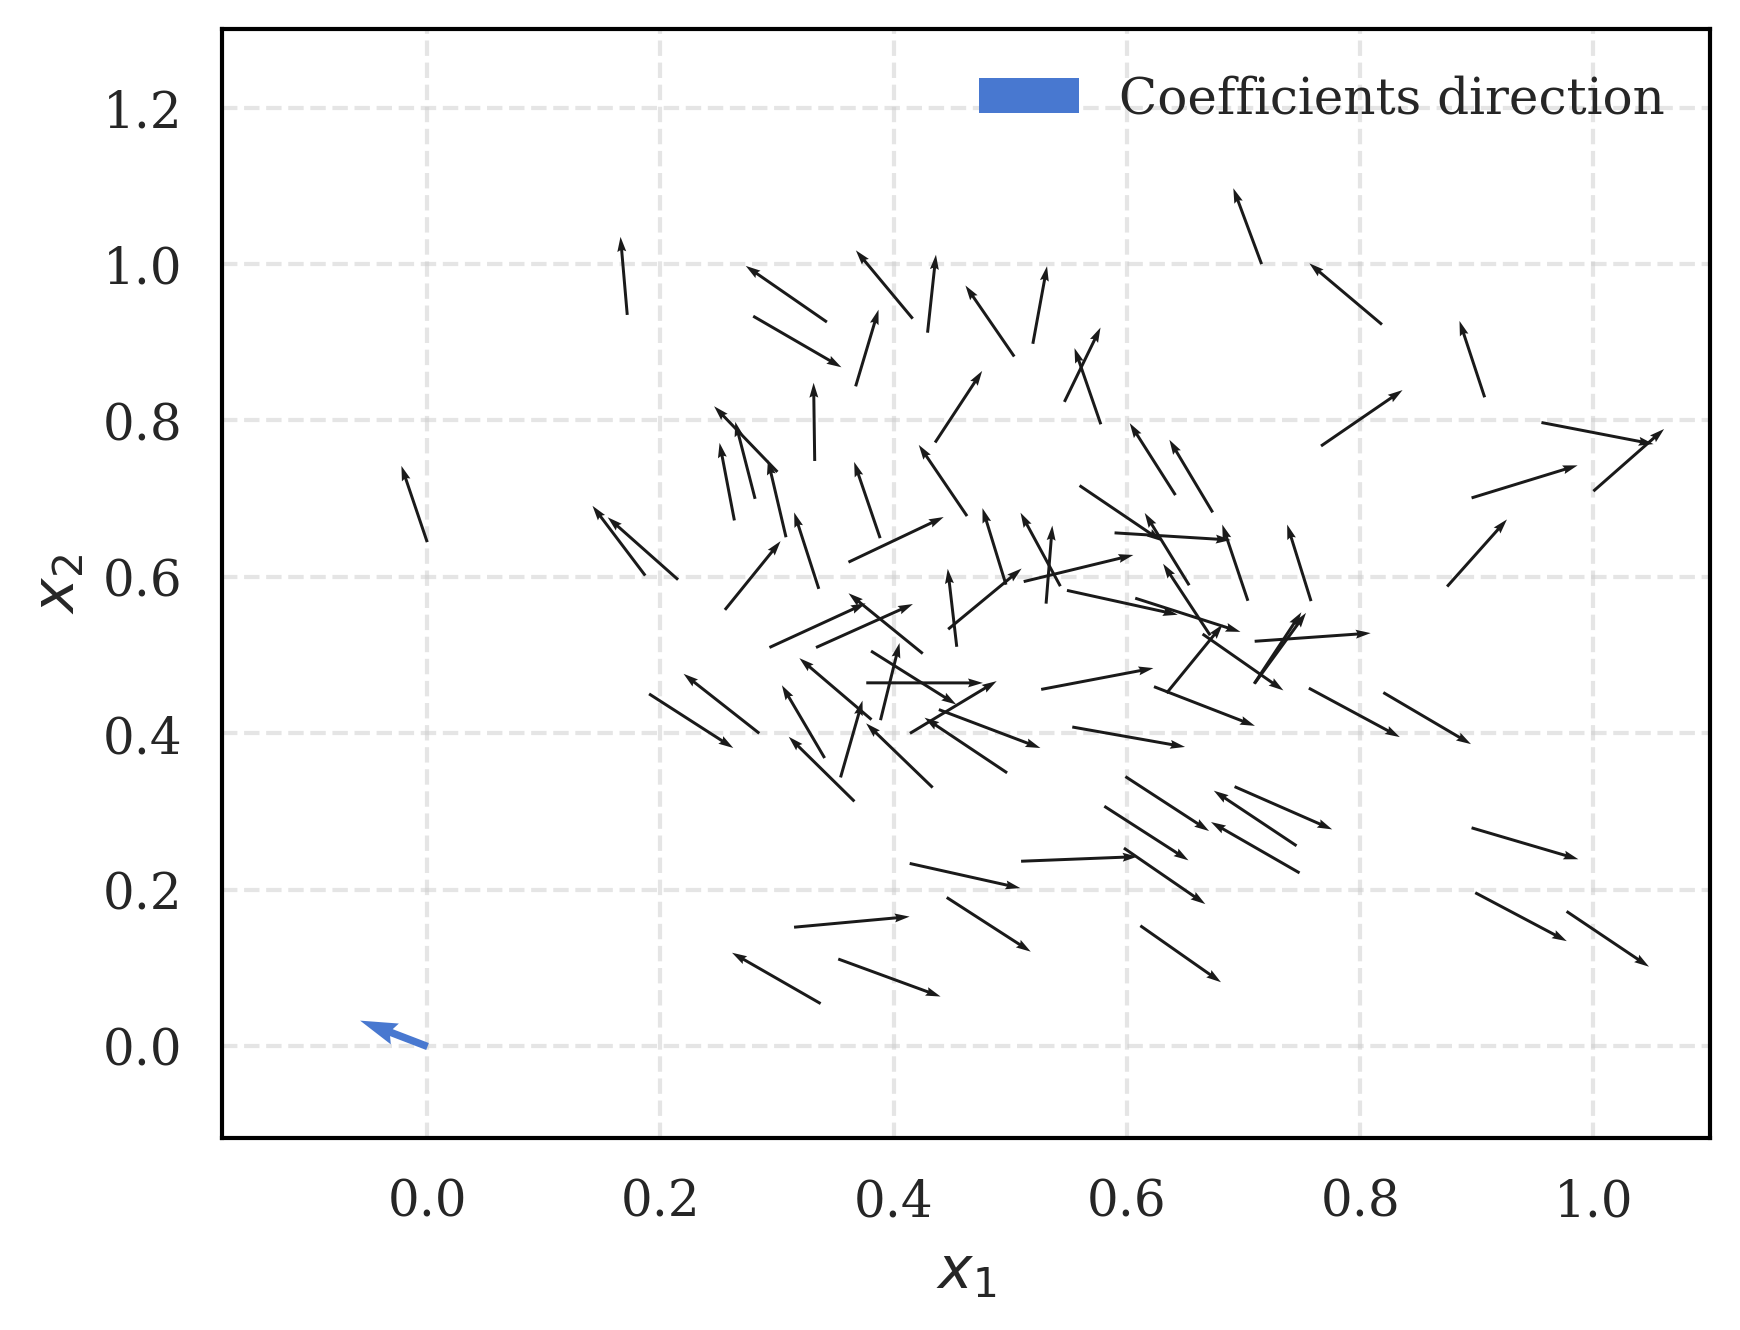

In [15]:
# Vector field of perturbations
torch.manual_seed(42)
np.random.seed(42)
def compute_perturbation(i):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    std = model.sample_predictive_distribution(x, 10000).std()
    appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)
    x_adv, x_adv_values = mlmc_attack(model, x, appd, R=10, lr=0.01, n_iter=400)
    return x_adv.clone().detach().numpy() - x.clone().detach().numpy()

perturbations = Parallel(n_jobs=-1)(delayed(compute_perturbation)(i) for i in range(X_test.shape[0]))

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)
# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=50, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0])-.1,max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1])-.1,max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.2)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

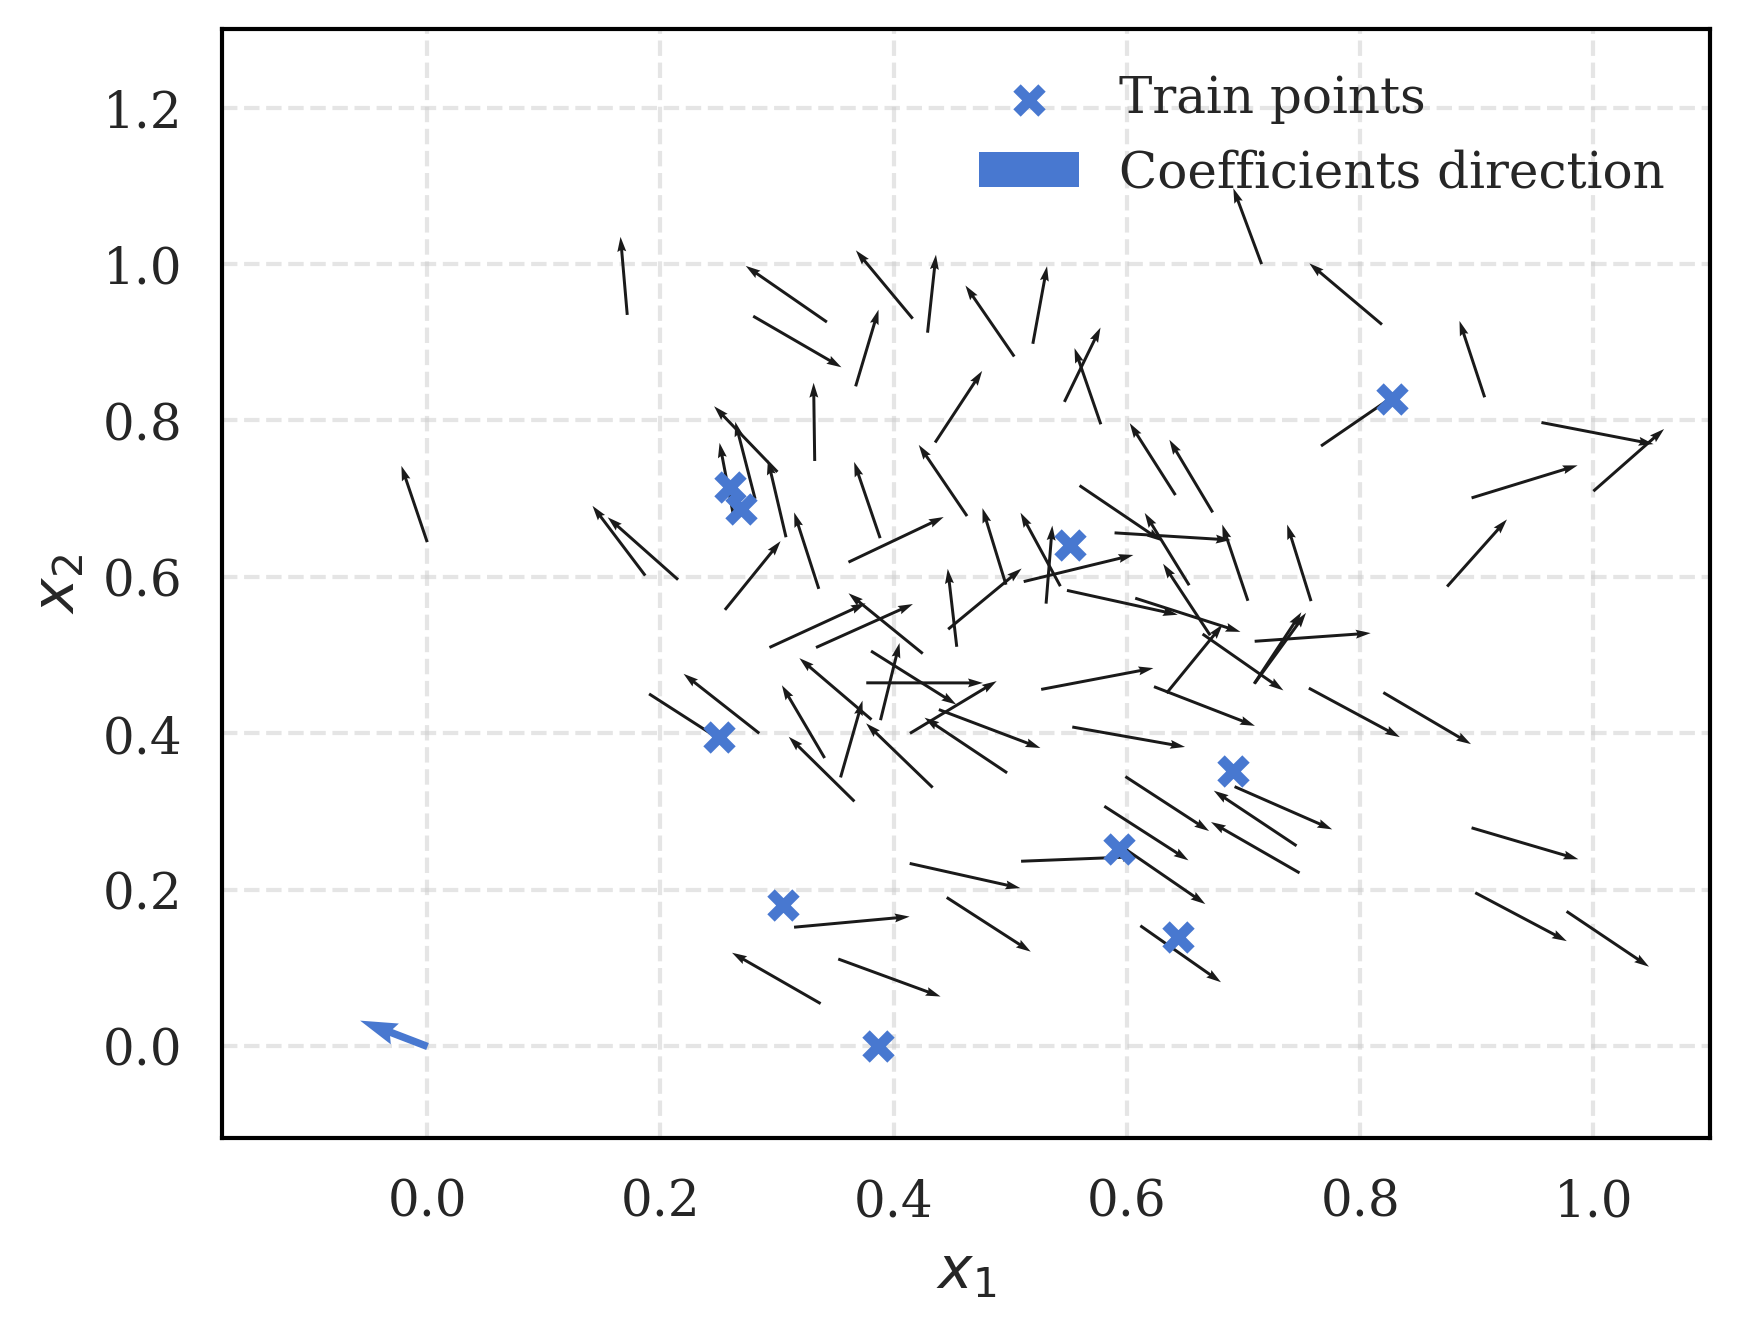

In [16]:
plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)
plt.scatter(X_train[:,0], X_train[:,1], marker='x', label='Train points')
# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=50, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0])-.1,max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1])-.1,max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.2)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

<>:39: SyntaxWarning: invalid escape sequence '\e'
<>:39: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_3170250/3537686546.py:39: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 12
Early stopping at iteration 19
Early stopping at iteration 56
Early stopping at iteration 24
Early stopping at iteration 198
Early stopping at iteration 45
Early stopping at iteration 265
Early stopping at iteration 36
Early stopping at iteration 438
Early stopping at iteration 456
Early stopping at iteration 43
Early stopping at iteration 500
Early stopping at iteration 71
Early stopping at iteration 63
Early stopping at iteration 626
Early stopping at iteration 697
Early stopping at iteration 92
Early stopping at iteration 748
Early stopping at iteration 766
Early stopping at iteration 732
Early stopping at iteration 100
Early stopping at iteration 814
Early stopping at iteration 841
Early stopping at iteration 124
Early stopping at iteration 131
Early stopping at iteration 188
Early stopping at iteration 125
Early stopping at iteration 957
Early stopping at iteration 916
Early stopping at it

Text(0, 0.5, 'KL Divergence')

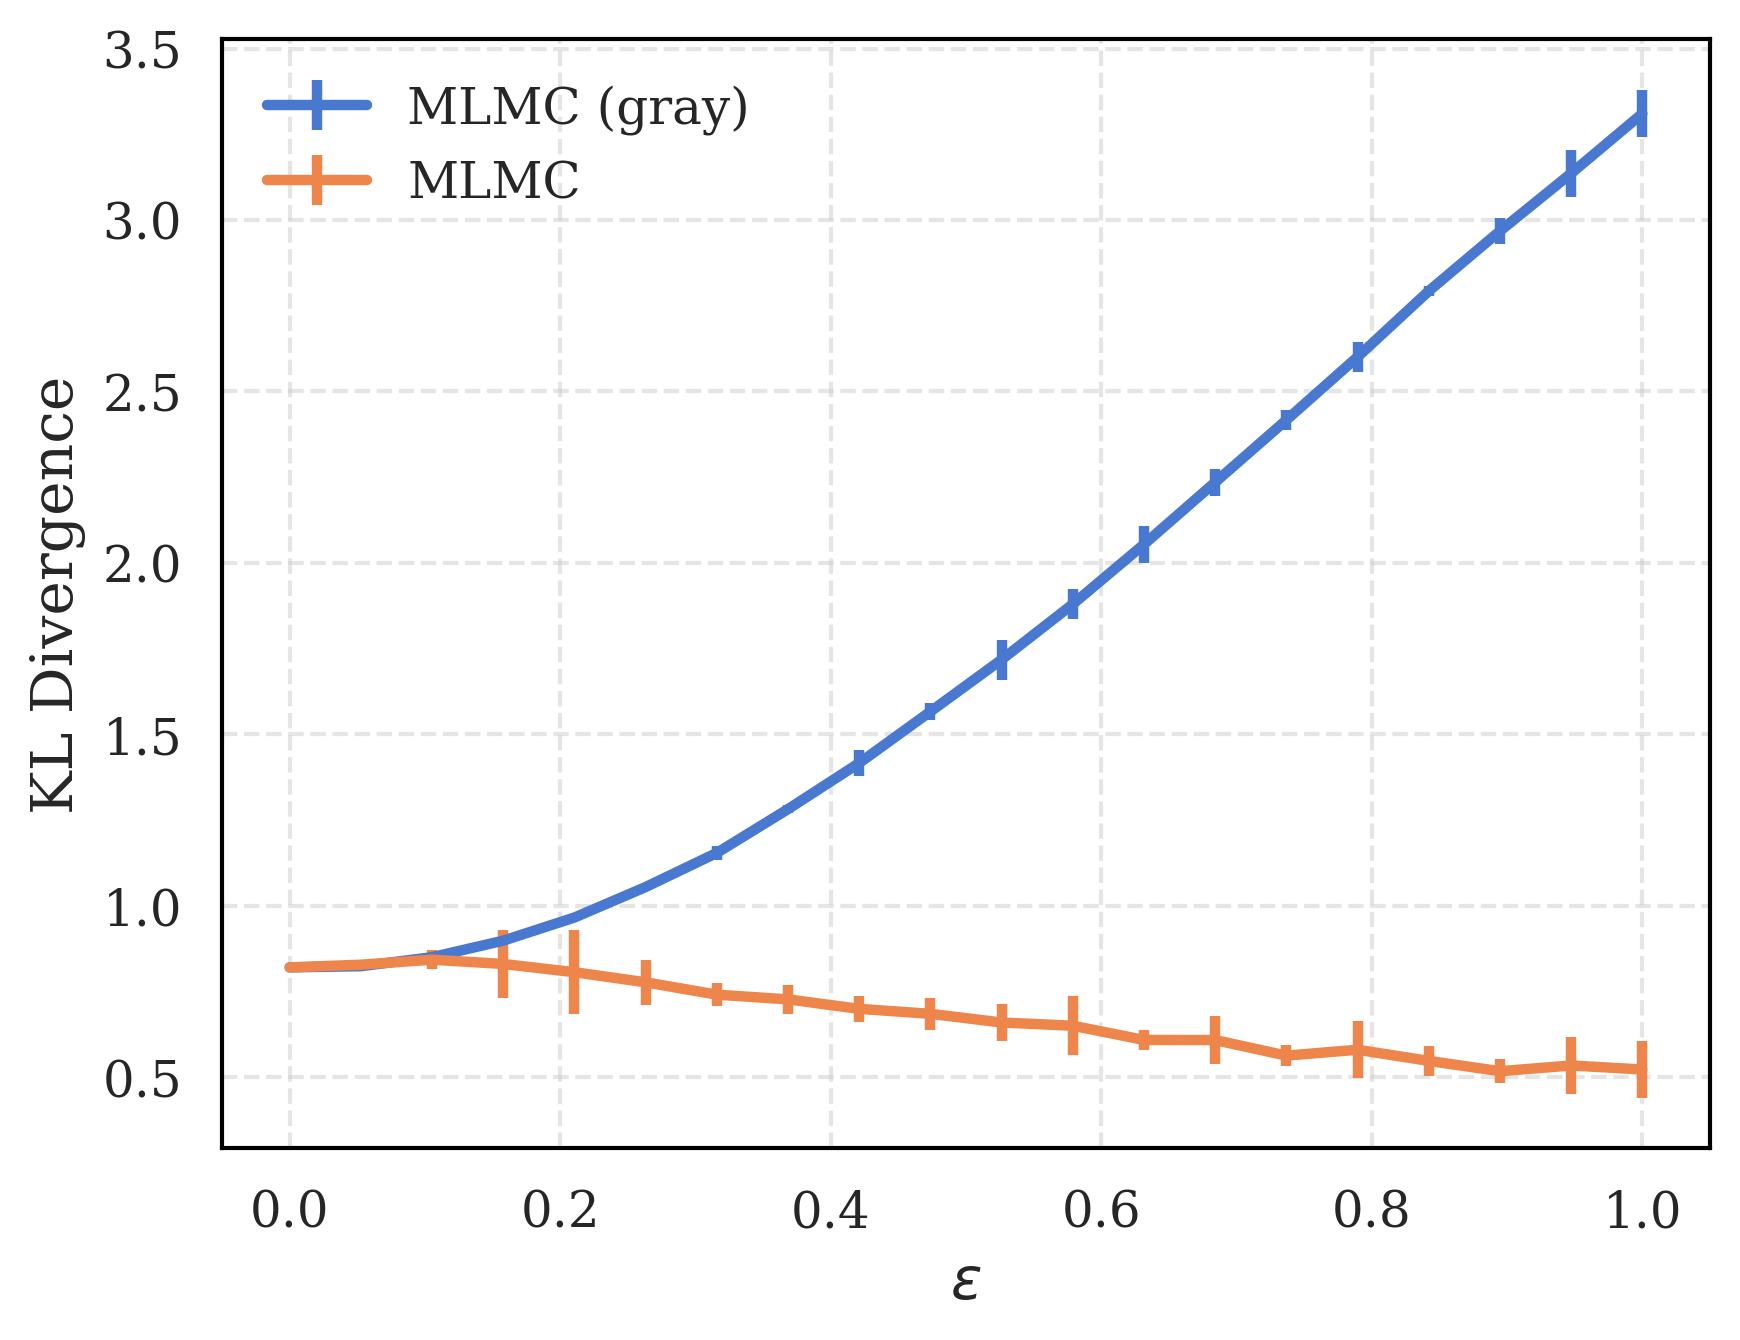

In [17]:
# plot KL divergence as a function of the strength of the attack  # AHORA CON LR = 0.01
n_jobs = -1
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=10, lr=0.01, n_iter=1000)
    kl = kl_to_appd(model.mu, model.lam, model.sigma2, x_adv_distr, x.T @ model.mu, 4 * std ** 2).item()
    x_fsgm = fgsm_attack(model, x, appd, epsilon=epsilon, R=10)
    kl_fsgm = kl_to_appd(model.mu, model.lam, model.sigma2, x_fsgm, x.T @ model.mu, 4 * std ** 2).item()
    x_gray, _ = mlmc_attack(model_adv, x, appd, epsilon=epsilon, R=10, lr=0.01, n_iter=1000)
    kl_gray = kl_to_appd(model.mu, model.lam, model.sigma2, x_gray, x.T @ model.mu, 4 * std ** 2).item()
    return kl, kl_fsgm, kl_gray


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
kl_gray = np.array(kl_alls)[:, :, 2]
# error bars as std
#plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_gray, axis=0, where=~np.isnan(kl_gray)), yerr=2*np.std(kl_gray, axis=0, where=~np.isnan(kl_gray)), label='MLMC (gray)')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), yerr=2*np.std(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_3170250/3267099618.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


(0.5, 1.0)

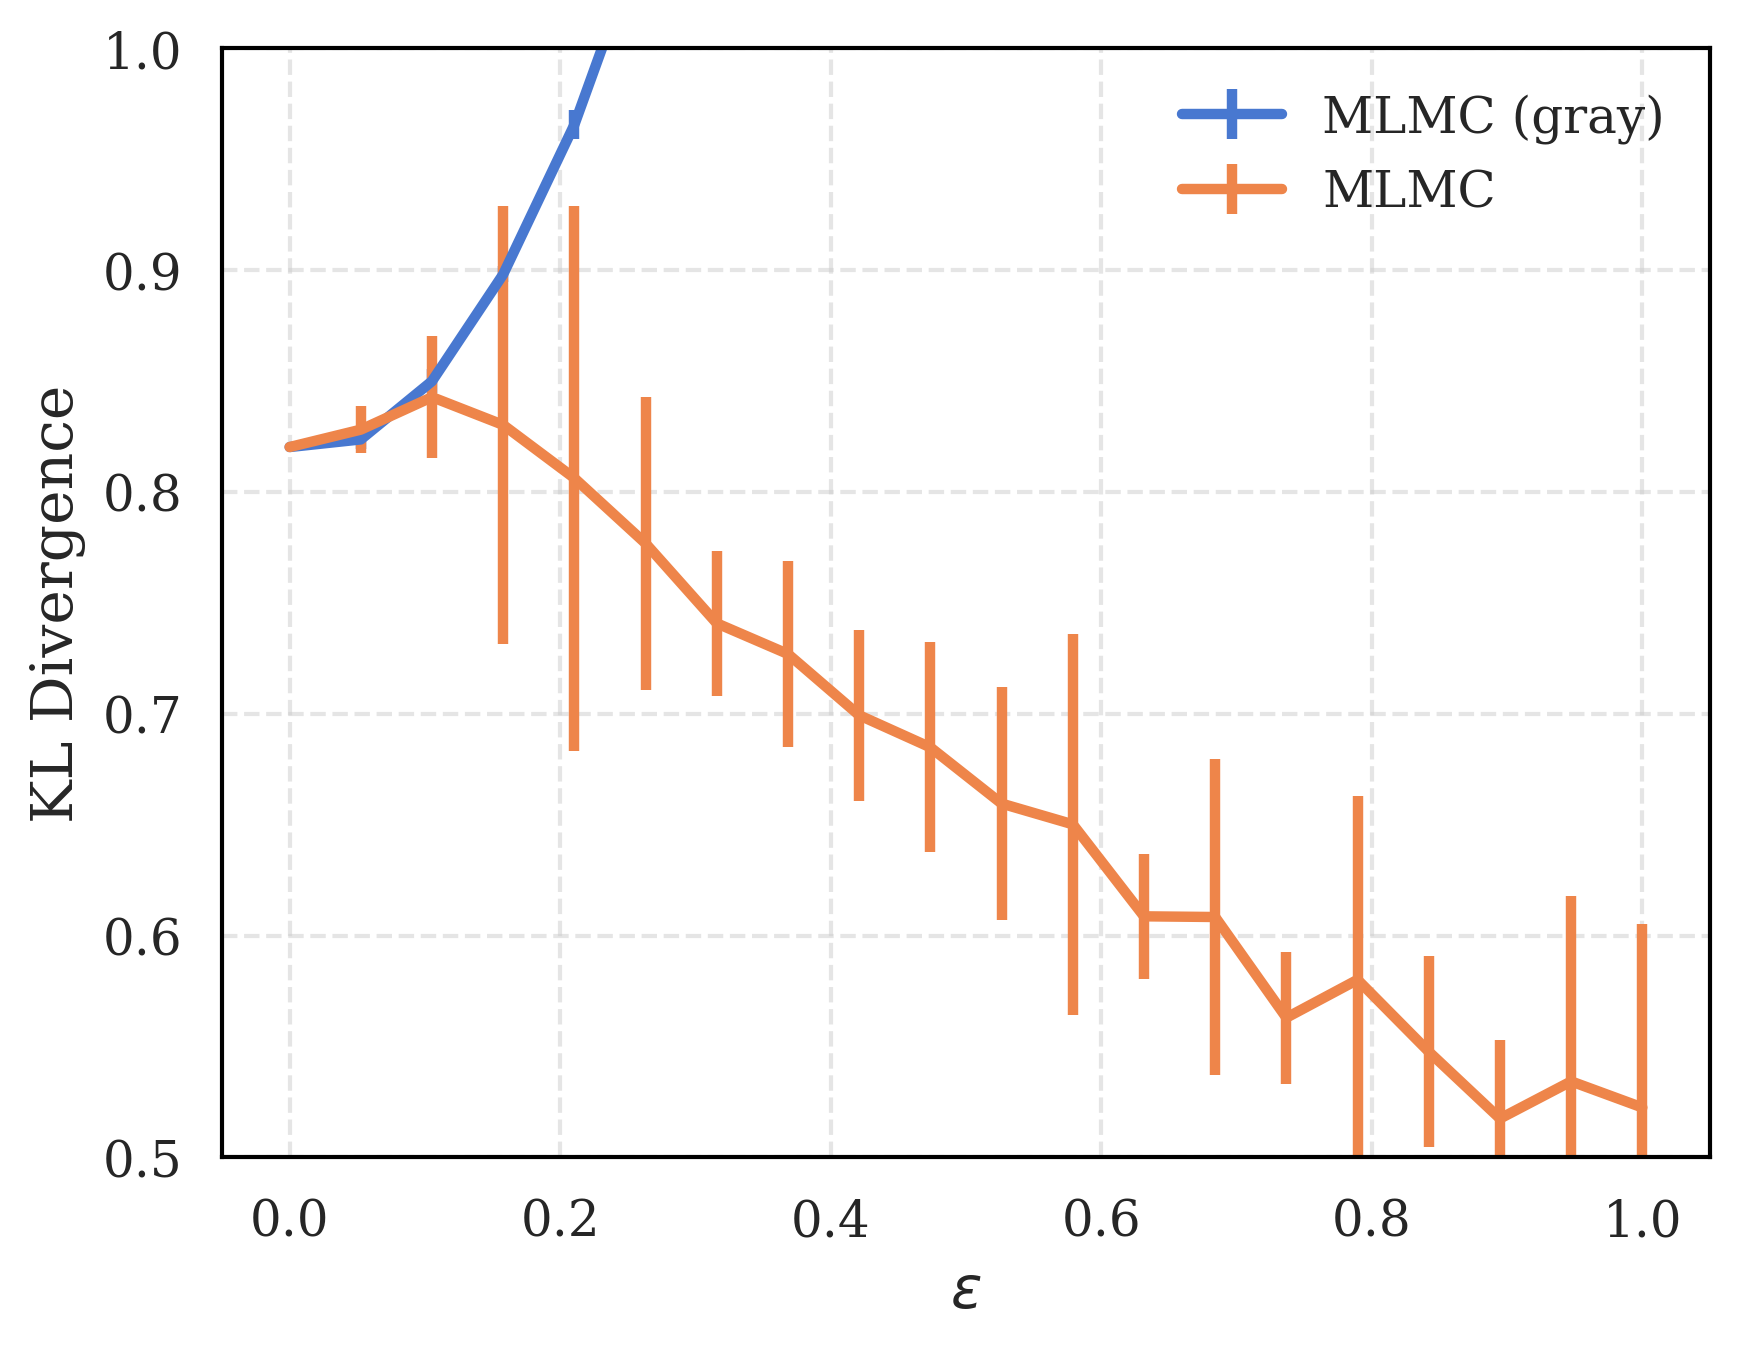

In [18]:
plt.errorbar(epsilons, np.mean(kl_gray, axis=0, where=~np.isnan(kl_gray)), yerr=2*np.std(kl_gray, axis=0, where=~np.isnan(kl_gray)), label='MLMC (gray)')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), yerr=2*np.std(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(0.5, 1)

## APPD = N(2+mu, 2*sigma)

Early stopping at iteration 145


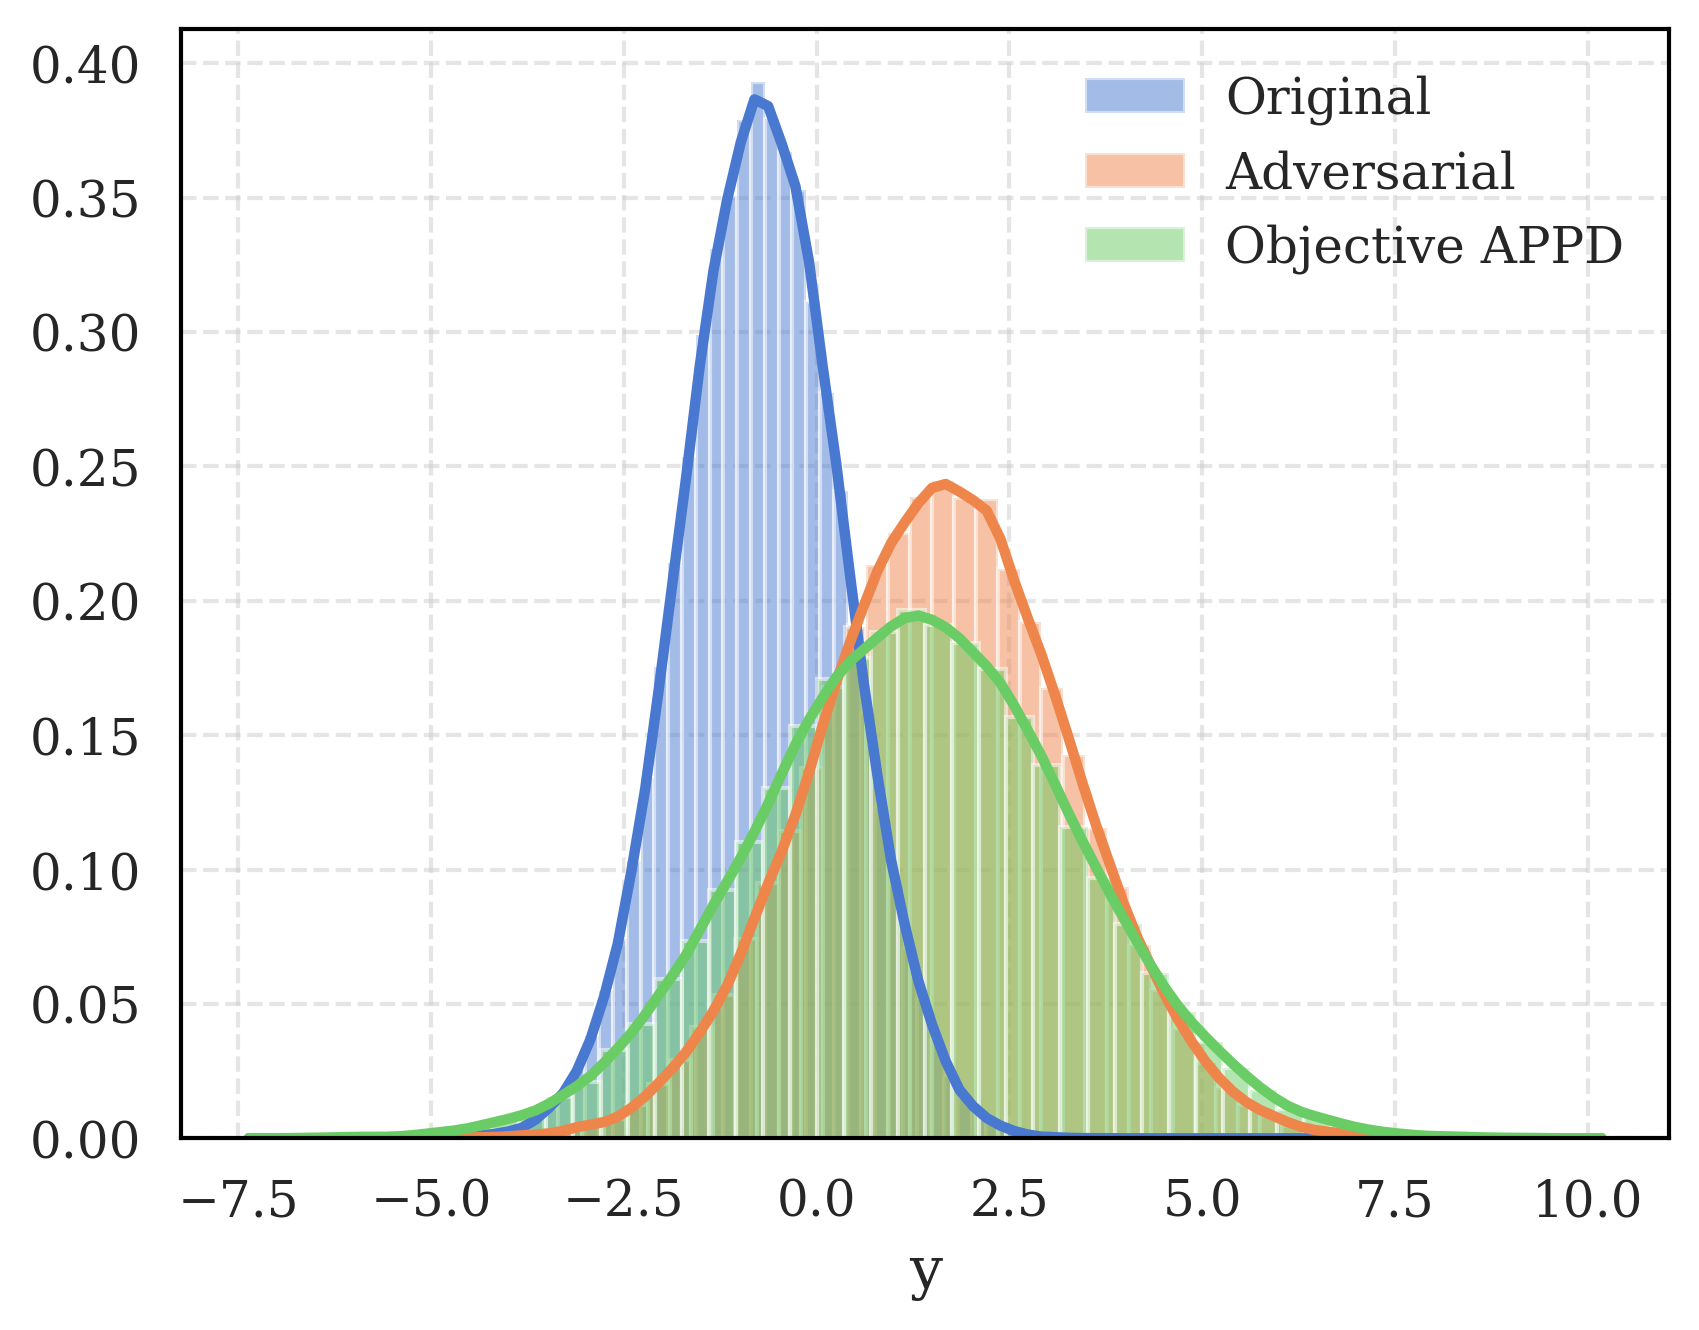

In [19]:
# Attack example
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=0.1, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

Early stopping at iteration 19
Early stopping at iteration 18
Early stopping at iteration 17
Early stopping at iteration 18
Early stopping at iteration 20
Early stopping at iteration 19
Early stopping at iteration 18
Early stopping at iteration 18
Early stopping at iteration 19
Early stopping at iteration 23
Early stopping at iteration 23
Early stopping at iteration 22
Early stopping at iteration 18
Early stopping at iteration 19
Early stopping at iteration 21
Early stopping at iteration 21
Early stopping at iteration 19
Early stopping at iteration 20
Early stopping at iteration 27
Early stopping at iteration 20
Early stopping at iteration 20
Early stopping at iteration 24
Early stopping at iteration 20
Early stopping at iteration 19
Early stopping at iteration 30
Early stopping at iteration 19
Early stopping at iteration 22
Early stopping at iteration 18
Early stopping at iteration 17
Early stopping at iteration 20
Early stopping at iteration 19
Early stopping at iteration 20
Early st

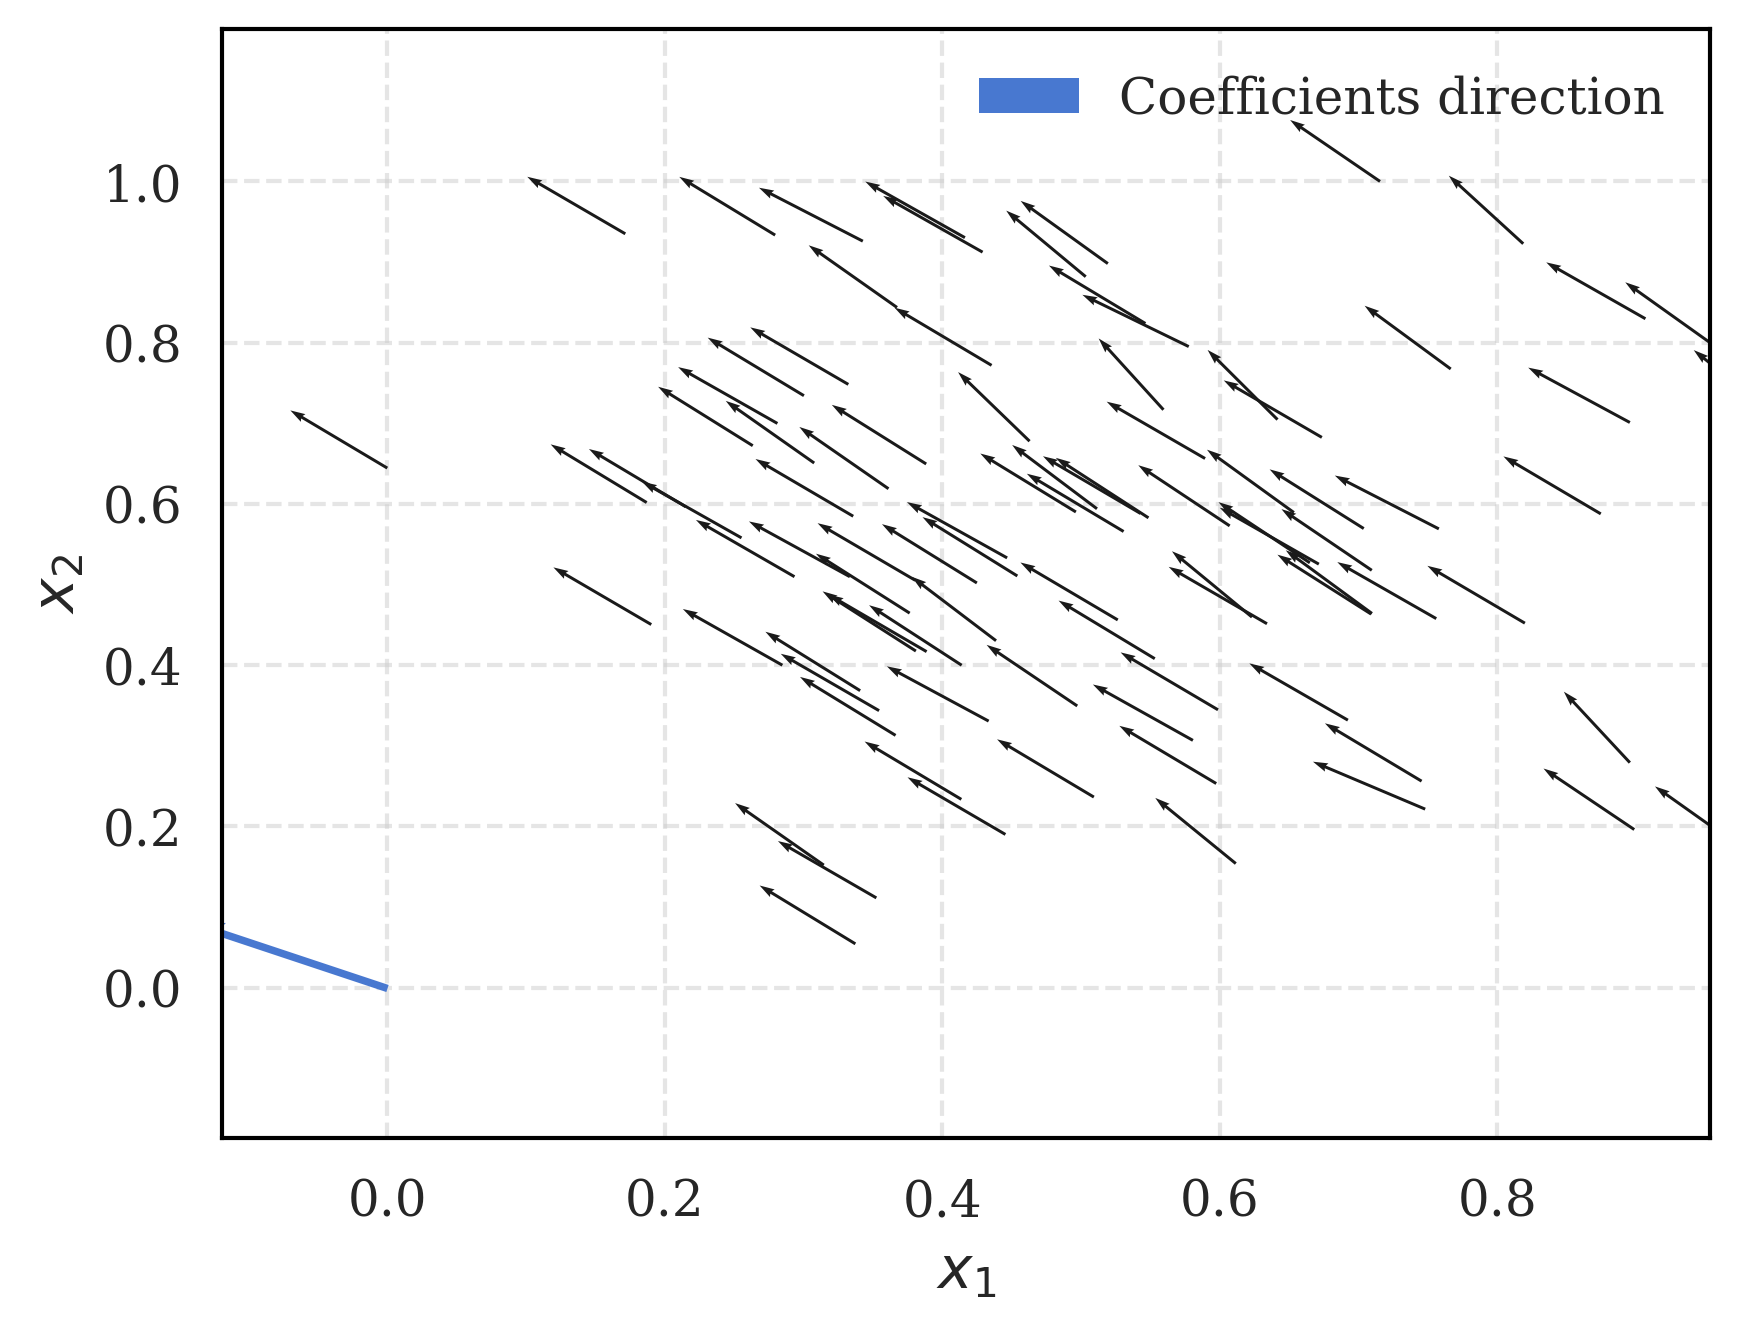

In [20]:
# Vector field of perturbations
def compute_perturbation(i):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    std = model.sample_predictive_distribution(x, 10000).std()
    appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)
    x_adv, x_adv_values = mlmc_attack(model, x, appd, R=10, lr=0.01, n_iter=400)
    return x_adv.clone().detach().numpy() - x.clone().detach().numpy()

perturbations = Parallel(n_jobs=-1)(delayed(compute_perturbation)(i) for i in range(X_test.shape[0]))

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=20, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) - min(np.array(perturbations)[:,0])-.2,max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1])-.3,max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

In [21]:
# plot KL divergence as a function of the strength of the attack AHORA CON LR=0.01
n_jobs = -1
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=10, lr=0.01, n_iter=1000)
    kl = kl_to_appd(model.mu, model.lam, model.sigma2, x_adv_distr, 2 + x.T @ model.mu, 4 * std ** 2).item()
    x_fsgm = fgsm_attack(model, x, appd, epsilon=epsilon, R=10)
    kl_fsgm = kl_to_appd(model.mu, model.lam, model.sigma2, x_fsgm, 2 + x.T @ model.mu, 4 * std ** 2).item()
    x_gray, _ = mlmc_attack(model_adv, x, appd, epsilon=epsilon, R=10, lr=0.01, n_iter=1000)
    kl_gray = kl_to_appd(model.mu, model.lam, model.sigma2, x_gray, 2 + x.T @ model.mu, 4 * std ** 2).item()
    return kl, kl_fsgm, kl_gray


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    #kl_values = [compute_kl_divergence(epsilon) for epsilon in epsilons]
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
kl_gray = np.array(kl_alls)[:, :, 2]
# error bars as std
#plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), yerr=2*np.std(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), label='MLMC')
plt.errorbar(epsilons, np.mean(kl_gray, axis=0, where=~np.isnan(kl_gray)), yerr=2*np.std(kl_gray, axis=0, where=~np.isnan(kl_gray)), label='MLMC (gray)')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')

<>:39: SyntaxWarning: invalid escape sequence '\e'
<>:39: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_3170250/3104907640.py:39: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 19
Early stopping at iteration 12
Early stopping at iteration 28
Early stopping at iteration 14
Early stopping at iteration 34
Early stopping at iteration 40
Early stopping at iteration 29
Early stopping at iteration 46
Early stopping at iteration 51
Early stopping at iteration 67
Early stopping at iteration 79
Early stopping at iteration 83
Early stopping at iteration 62
Early stopping at iteration 103
Early stopping at iteration 119
Early stopping at iteration 121
Early stopping at iteration 86
Early stopping at iteration 123
Early stopping at iteration 100
Early stopping at iteration 110
Early stopping at iteration 85
Early stopping at iteration 116
Early stopping at iteration 141
Early stopping at iteration 140
Early stopping at iteration 135
Early stopping at iteration 254
Early stopping at iteration 317
Early stopping at iteration 383
Early stopping at iteration 296
Early stopping at iterati

/tmp/ipykernel_3170250/3104907640.py:39: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


KeyboardInterrupt: 

## Maximum disruption problem

In [22]:
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = x.clone().detach().requires_grad_(True)  
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

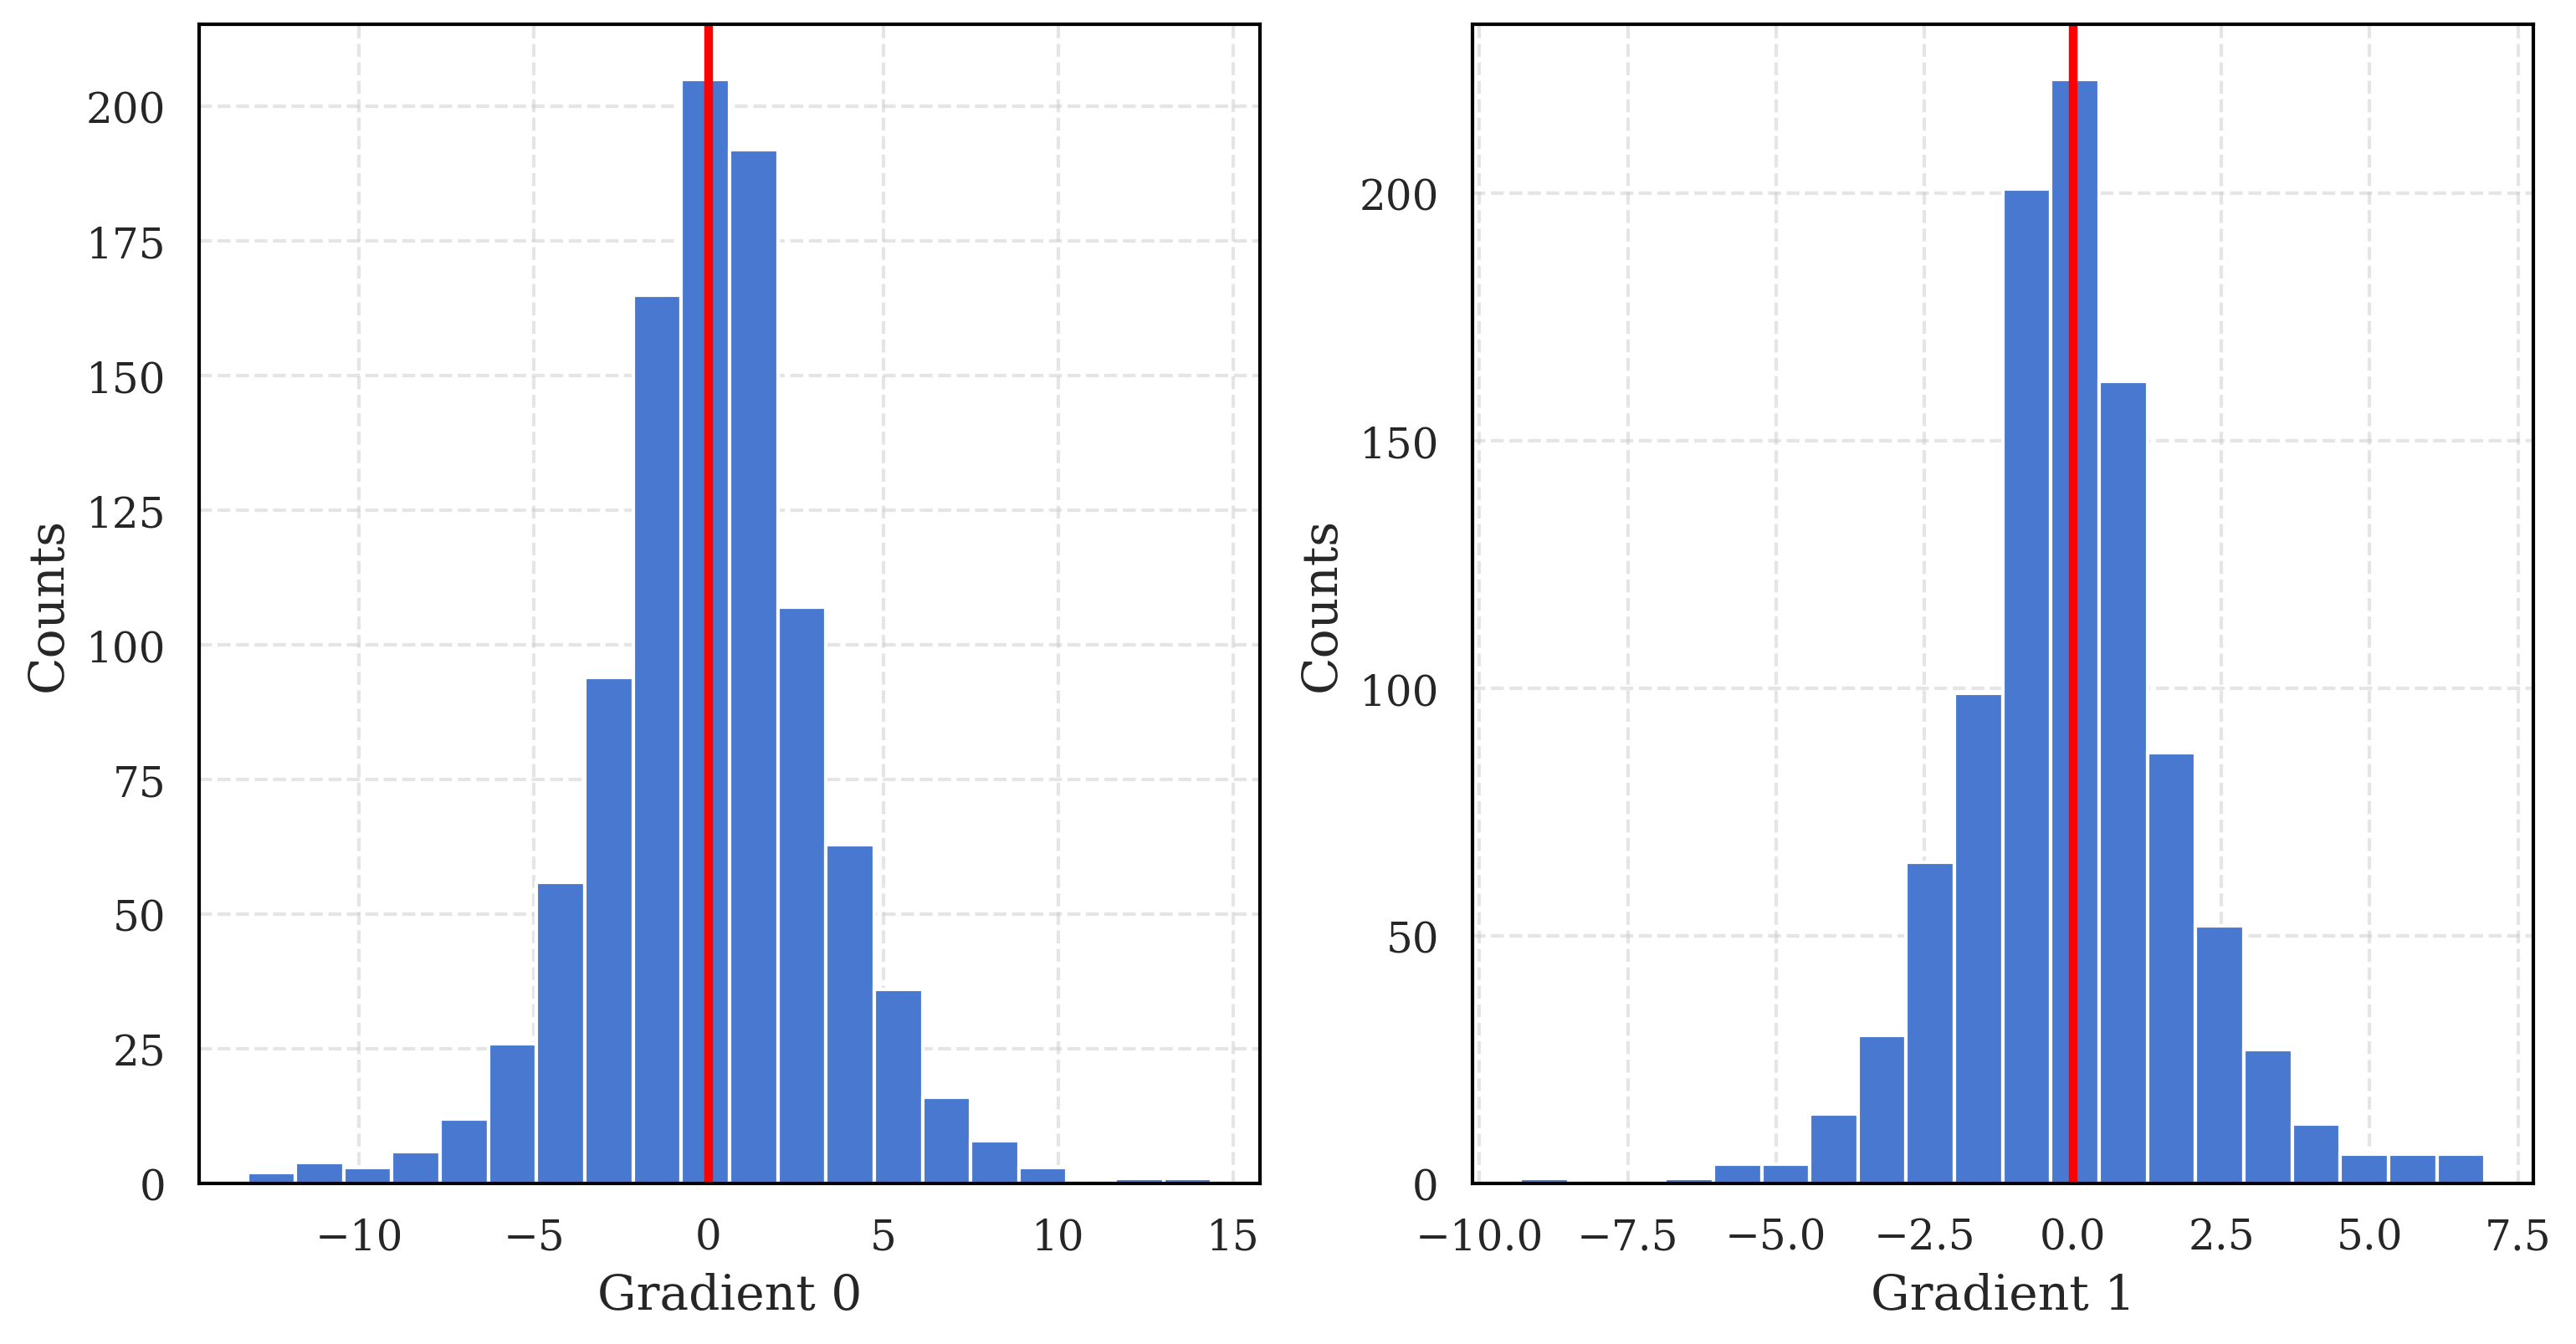

In [23]:
grads = []
for it in range(1000):  # TODO: change to 10000
    y = model.sample_predictive_distribution(x, num_samples=1)
    grads.append(mlmc_gradient_estimator(y, x_adv, 10, model))

# Plot 2 histograms, one for each feature
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].hist([grad[i].item() for grad in grads], bins=20)
    axs[i].axvline(real_grad[i].item(), color='red')
    axs[i].set_xlabel(f'Gradient {i}')
    axs[i].set_ylabel('Counts')

Early stopping at iteration 68


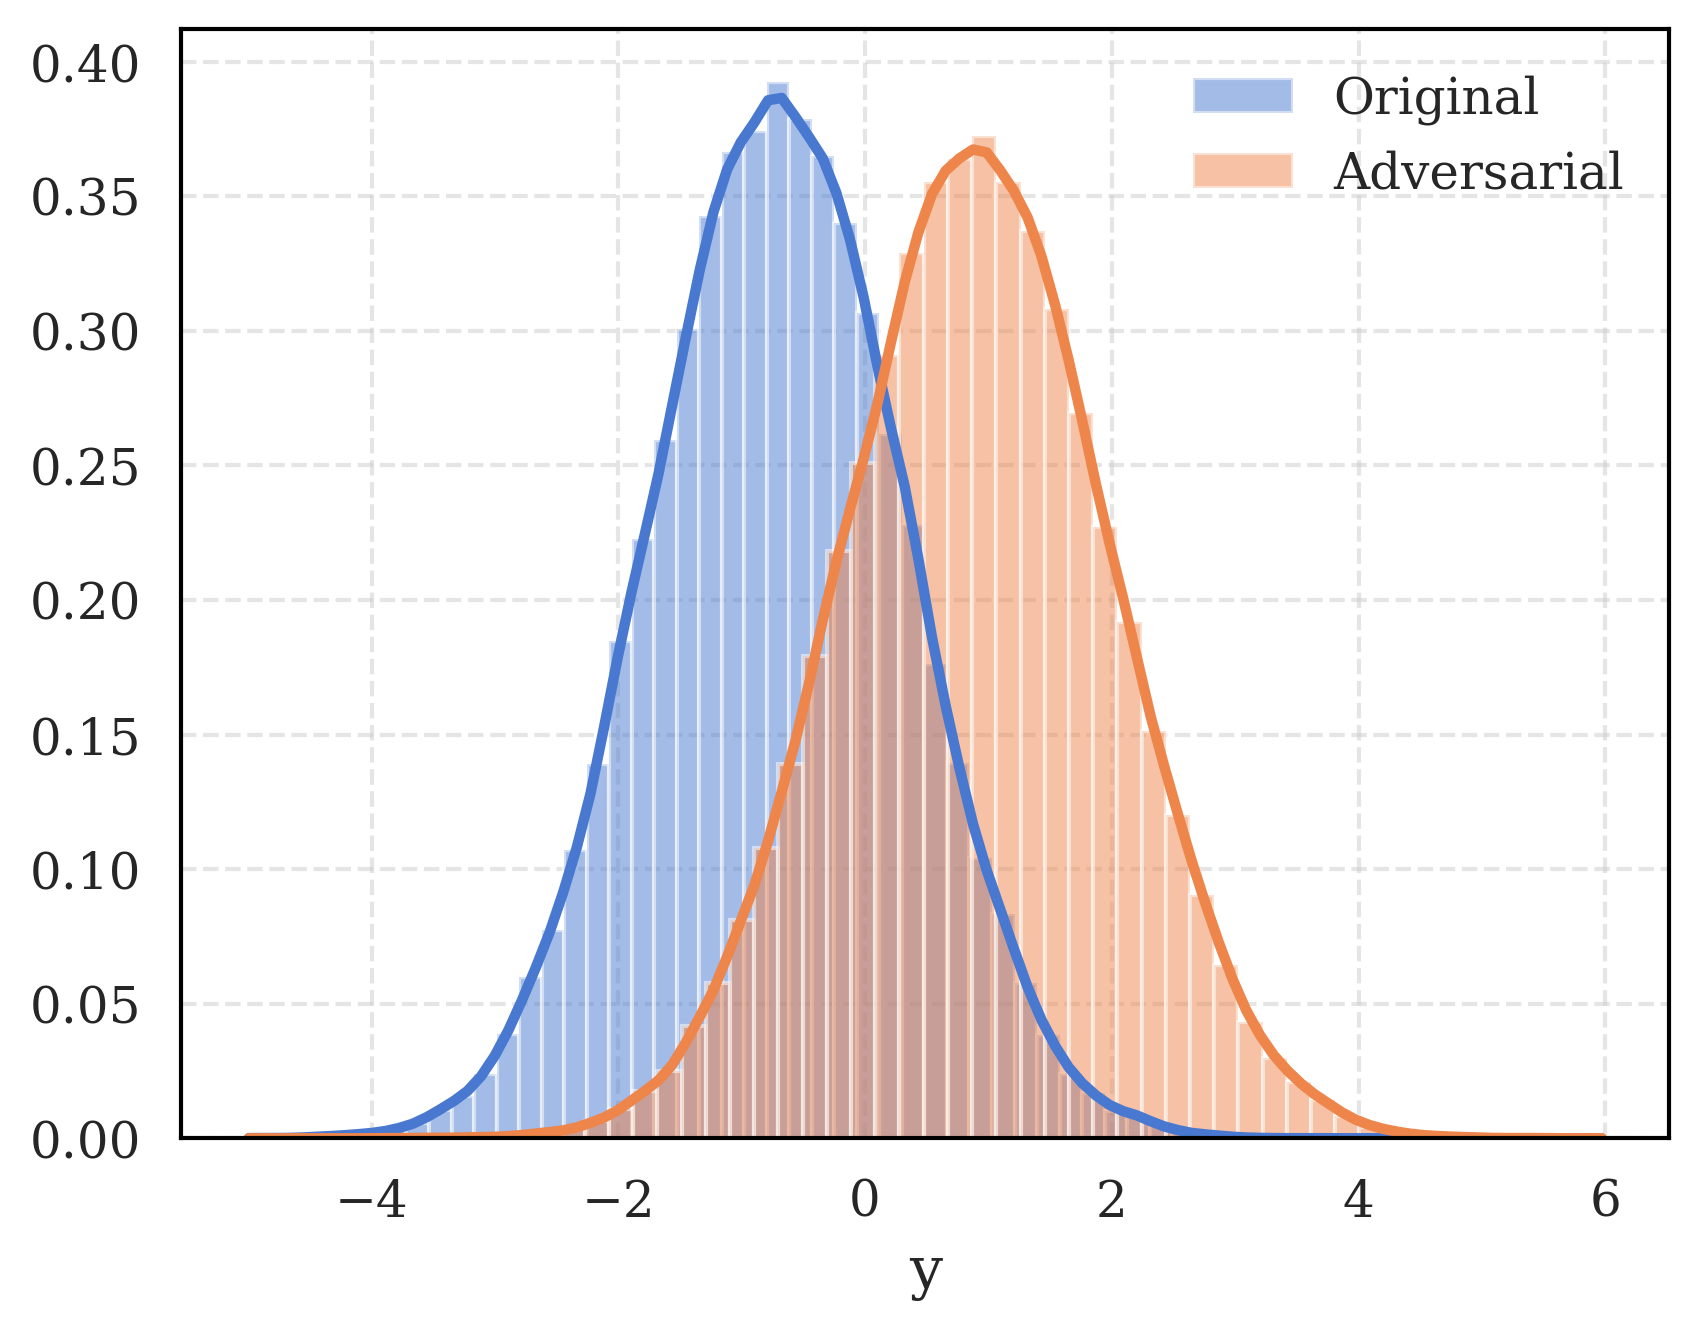

In [34]:
# Attack example
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=.5, R=10, lr=0.01, n_iter=400)
plot_ppds(model, x, x_adv_distr)

Early stopping at iteration 50
Early stopping at iteration 35
Early stopping at iteration 54
Early stopping at iteration 29
Early stopping at iteration 23
Early stopping at iteration 35
Early stopping at iteration 66
Early stopping at iteration 116
Early stopping at iteration 151
Early stopping at iteration 22
Early stopping at iteration 52
Early stopping at iteration 54
Early stopping at iteration 27
Early stopping at iteration 82
Early stopping at iteration 20
Early stopping at iteration 77
Early stopping at iteration 19
Early stopping at iteration 45
Early stopping at iteration 58
Early stopping at iteration 22
Early stopping at iteration 77
Early stopping at iteration 100
Early stopping at iteration 57
Early stopping at iteration 38
Early stopping at iteration 18
Early stopping at iteration 130
Early stopping at iteration 37
Early stopping at iteration 73
Early stopping at iteration 81
Early stopping at iteration 48
Early stopping at iteration 83
Early stopping at iteration 73
Earl

Early stopping at iteration 41
Early stopping at iteration 86
Early stopping at iteration 22
Early stopping at iteration 30
Early stopping at iteration 116
Early stopping at iteration 23
Early stopping at iteration 18
Early stopping at iteration 33
Early stopping at iteration 18
Early stopping at iteration 62
Early stopping at iteration 41
Early stopping at iteration 21
Early stopping at iteration 27
Early stopping at iteration 78
Early stopping at iteration 127
Early stopping at iteration 29
Early stopping at iteration 24
Early stopping at iteration 24
Early stopping at iteration 33
Early stopping at iteration 81
Early stopping at iteration 50
Early stopping at iteration 18
Early stopping at iteration 55
Early stopping at iteration 23
Early stopping at iteration 38
Early stopping at iteration 19
Early stopping at iteration 78
Early stopping at iteration 104
Early stopping at iteration 23
Early stopping at iteration 46
Early stopping at iteration 49
Early stopping at iteration 23
Early

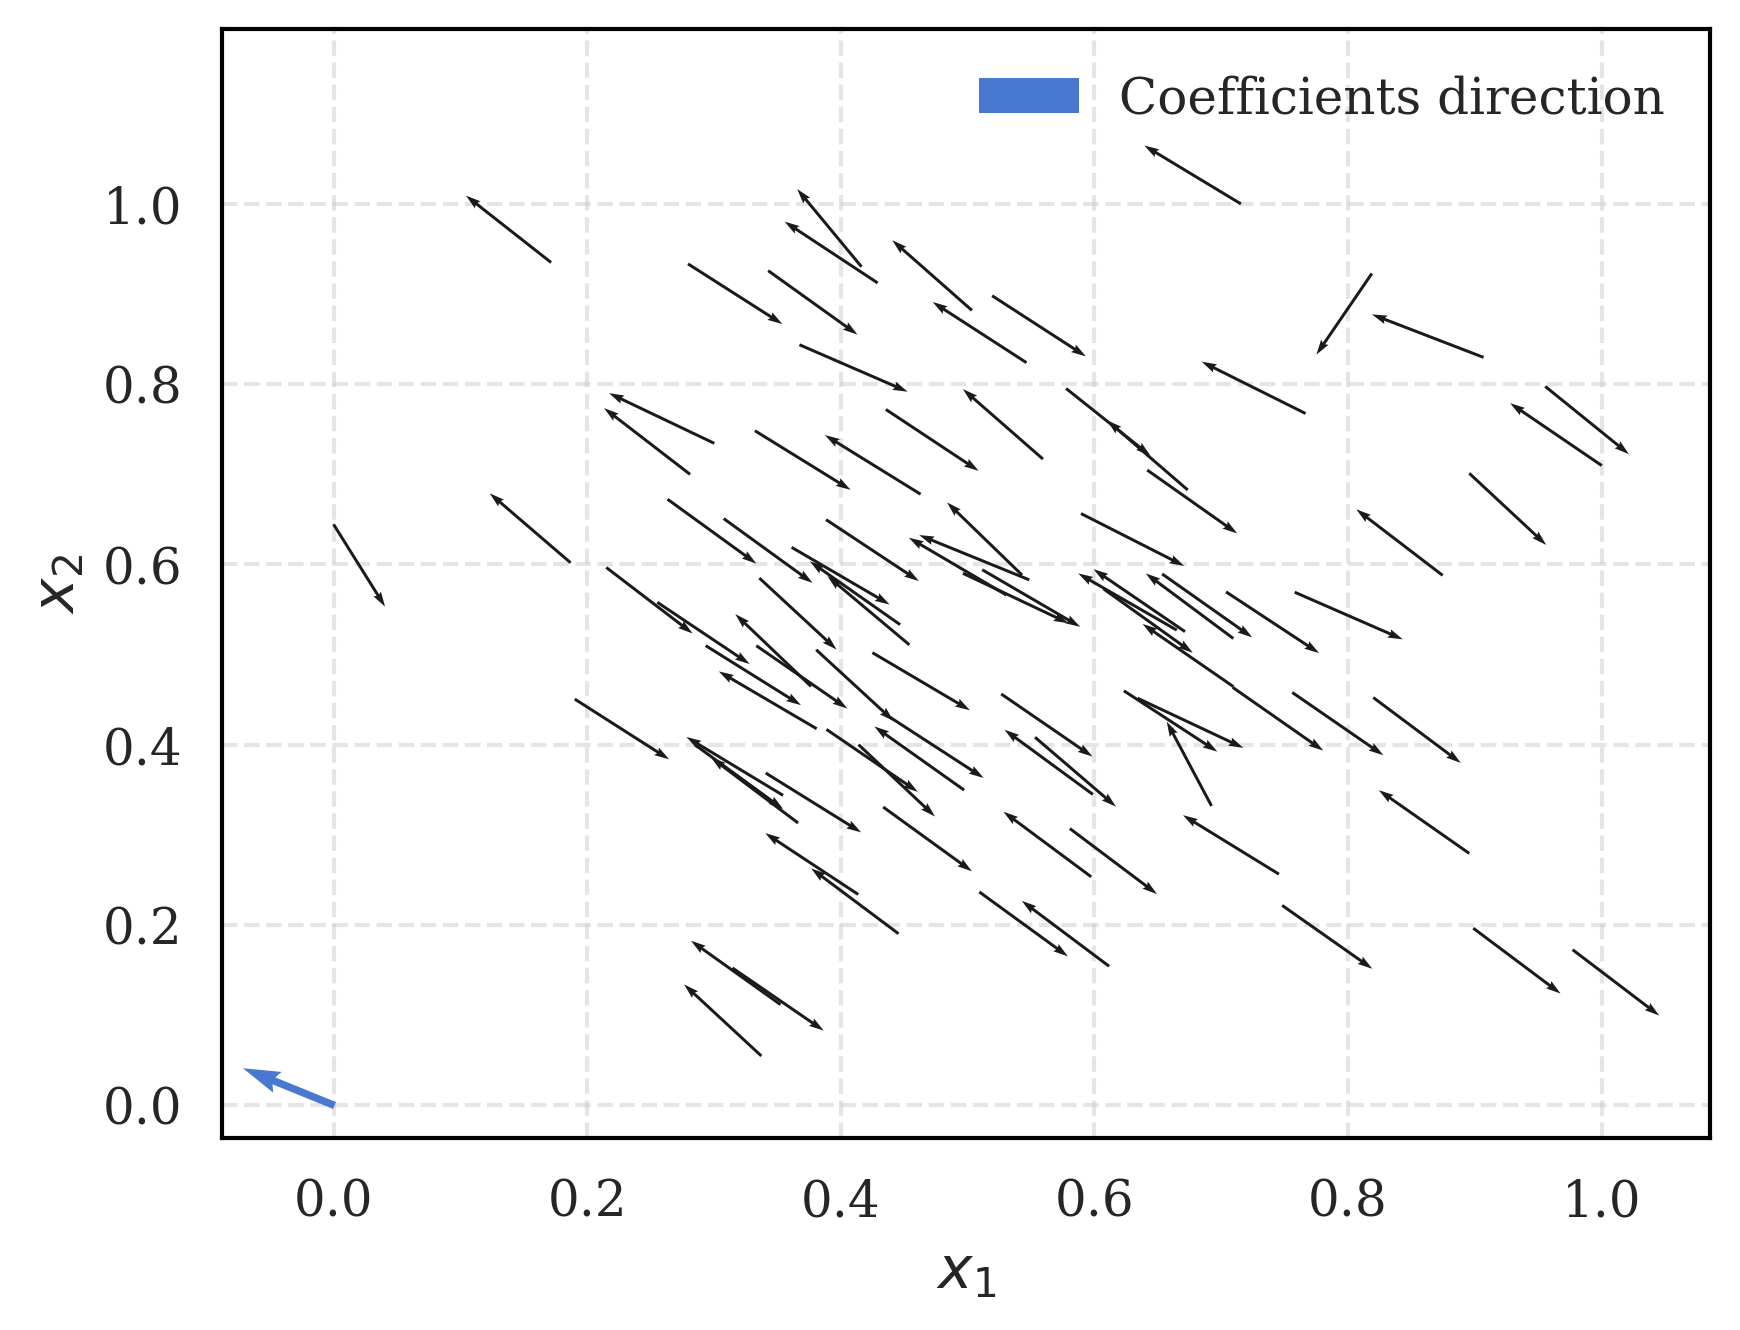

In [24]:
# Vector field of perturbations
perturbations = []

for i in range(X_test.shape[0]):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    x_adv, x_adv_values = mlmc_attack(model, x, R=10, lr=0.01)
    perturbations.append(x_adv.clone().detach().numpy() - x.clone().detach().numpy())

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=40, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0]),max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_3177468/613179718.py:30: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Early stopping at iteration 12
Early stopping at iteration 23
Early stopping at iteration 29
Early stopping at iteration 22
Early stopping at iteration 42
Early stopping at iteration 67
Early stopping at iteration 71
Early stopping at iteration 70
Early stopping at iteration 73
Early stopping at iteration 87
Early stopping at iteration 93
Early stopping at iteration 105
Early stopping at iteration 110
Early stopping at iteration 112
Early stopping at iteration 124
Early stopping at iteration 74
Early stopping at iteration 139
Early stopping at iteration 142
Early stopping at iteration 145
Early stopping at iteration 185
Early stopping at iteration 12
Early stopping at iteration 43
Early stopping at iteration 51
Early stopping at iteration 50
Early stopping at iteration 51
Early stopping at iteration 56
Early stopping at iteration 43
Early stopping at iteration 73
Early stopping at iteration 80
Early stopping at iteration 80
Early stopping at iteration 85
Early stopping at iteration 89


Text(0, 0.5, 'KL Divergence')

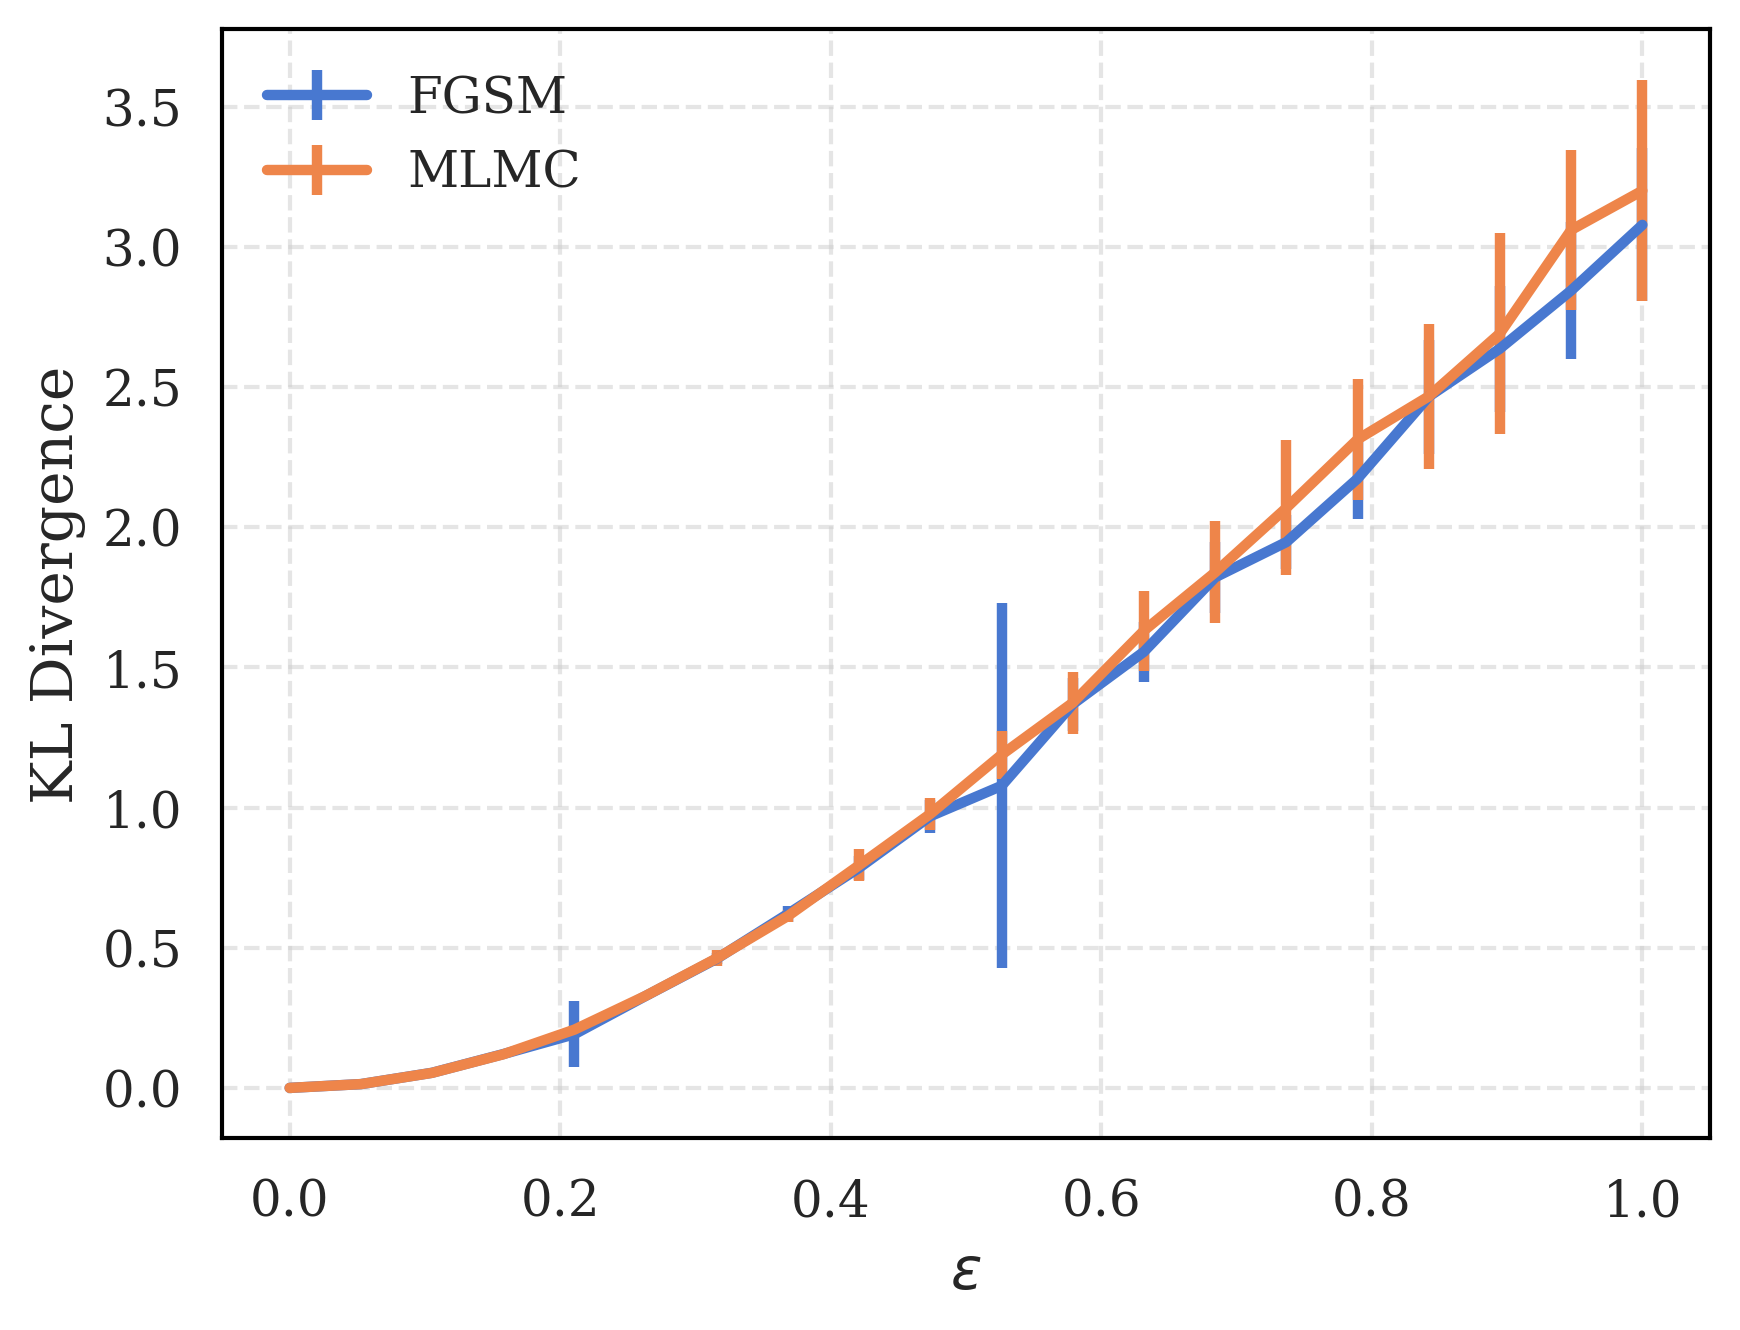

In [14]:
# plot KL divergence as a function of the strength of the attack 
n_jobs = 66
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=10)
    kl = kl_div(model.mu, model.lam, model.sigma2, x, x_adv_distr).item()
    x_fsgm = fgsm_attack(model, x, epsilon=epsilon, R=10)
    kl_fsgm = kl_div(model.mu, model.lam, model.sigma2, x, x_fsgm).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')